# ViT Base with patch size 4 on CIFAR-10

# 1. Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 2. Hyperparameters

In [ ]:
BATCH_SIZE = 128
PATCH_SIZE = 4  #32x32 / 4x4 = 8x8 patches
NUM_CLASSES = 10
EPOCHS = 20
LR = 3e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 3. Patch + Positional Embedding

In [ ]:
class PatchEmbed(nn.Module):
  def __init__(self,img_size=32,patch_size=4,in_ch=3,embed_dim=256):
    super().__init__()
    self.n_patches=(img_size//patch_size)**2
    self.proj=nn.Conv2d(in_ch,embed_dim,kernel_size=patch_size,stride=patch_size)
    self.cls_token=nn.Parameter(torch.zeros(1,1,embed_dim))
    self.pos_embed=nn.Parameter(torch.zeros(1,self.n_patches+1,embed_dim))

  def forward(self,x):
    B=x.shape[0]
    x=self.proj(x).flatten(2).transpose(1,2) #(B,N,D)
    cls_token=self.cls_token.expand(B,-1,-1) #(B,1,D)
    x=torch.cat((cls_token,x),dim=1) #(B,N+1,D)
    x=x+self.pos_embed
    return x

# 4. Multihead Self Attention

In [ ]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"

        # Linear projection for Q, K, V combined
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.out = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        B, N, D = x.shape  # Batch, sequence length, embedding dim

        # Project to q, k, v and reshape for multi-head attention
        qkv = self.qkv(x)  # (B, N, 3 * D)
        qkv = qkv.reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # (3, B, heads, N, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attn = attn.softmax(dim=-1)
        out = (attn @ v).transpose(1, 2).reshape(B, N, D)
        return self.out(out)


# 5. Transformer Encoder Block

In [ ]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,embed_dim=256,num_heads=8,mlp_ratio=4.0,dropout=0.1):
    super().__init__()
    self.norm1=nn.LayerNorm(embed_dim)
    self.attn=MultiHeadSelfAttention(embed_dim,num_heads)
    self.norm2=nn.LayerNorm(embed_dim)
    self.mlp=nn.Sequential(
        nn.Linear(embed_dim,int(embed_dim*mlp_ratio)),
        nn.GELU(),
        nn.Linear(int(embed_dim*mlp_ratio),embed_dim),
        nn.Dropout(dropout),
    )
  def forward(self,x):
    x=x+self.attn(self.norm1(x))
    x=x+self.mlp(self.norm2(x))
    return x

# 6. ViT class

In [ ]:
class ViT(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_ch=3, num_classes=10, embed_dim=256, depth=6, num_heads=8):
        super().__init__()
        self.patch_embed = PatchEmbed(img_size, patch_size, in_ch, embed_dim)
        self.encoder_blocks = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, num_heads) for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x, visualize=False):
        x = self.patch_embed(x)
        for blk in self.encoder_blocks:
            x = blk(x)
        # if visualization mode, return attention weights from last block
        if visualize:
            return self.encoder_blocks[-1].attn.attn_weights
        x = self.norm(x[:, 0])
        return self.head(x)


# 7.Dataset & DataLoaders

In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2470, 0.2435, 0.2616])

])

In [ ]:
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

100%|██████████| 170M/170M [00:14<00:00, 11.9MB/s]


# 8.Training Loop

In [ ]:

def train_model(model, optimizer, criterion, trainloader, testloader):
    train_accs, test_accs = [], []
    for epoch in range(EPOCHS):
        model.train()
        correct, total = 0, 0
        for x, y in trainloader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            pred = out.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
        train_acc = correct / total

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for x, y in testloader:
                x, y = x.to(DEVICE), y.to(DEVICE)
                out = model(x)
                pred = out.argmax(dim=1)
                correct += (pred == y).sum().item()
                total += y.size(0)
        test_acc = correct / total
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        print(f"Epoch {epoch+1}/{EPOCHS} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")
    return train_accs, test_accs


# 9. Training ViT

In [ ]:
vit = ViT().to(DEVICE)
vit_opt = torch.optim.Adam(vit.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()


print("Training Vision Transformer...")
vit_train_acc, vit_test_acc = train_model(vit, vit_opt, criterion, trainloader, testloader)

Training Vision Transformer...
Epoch 1/20 | Train Acc: 0.3150 | Test Acc: 0.4095
Epoch 2/20 | Train Acc: 0.4881 | Test Acc: 0.5219
Epoch 3/20 | Train Acc: 0.5541 | Test Acc: 0.5437
Epoch 4/20 | Train Acc: 0.5869 | Test Acc: 0.5839
Epoch 5/20 | Train Acc: 0.6108 | Test Acc: 0.5994
Epoch 6/20 | Train Acc: 0.6299 | Test Acc: 0.6206
Epoch 7/20 | Train Acc: 0.6463 | Test Acc: 0.6196
Epoch 8/20 | Train Acc: 0.6581 | Test Acc: 0.6370
Epoch 9/20 | Train Acc: 0.6705 | Test Acc: 0.6301
Epoch 10/20 | Train Acc: 0.6855 | Test Acc: 0.6478
Epoch 11/20 | Train Acc: 0.6962 | Test Acc: 0.6437
Epoch 12/20 | Train Acc: 0.7074 | Test Acc: 0.6510
Epoch 13/20 | Train Acc: 0.7212 | Test Acc: 0.6565
Epoch 14/20 | Train Acc: 0.7311 | Test Acc: 0.6504
Epoch 15/20 | Train Acc: 0.7422 | Test Acc: 0.6504
Epoch 16/20 | Train Acc: 0.7573 | Test Acc: 0.6634
Epoch 17/20 | Train Acc: 0.7659 | Test Acc: 0.6629
Epoch 18/20 | Train Acc: 0.7803 | Test Acc: 0.6493
Epoch 19/20 | Train Acc: 0.7936 | Test Acc: 0.6583
Epoch 20/

# 10. Training ResNet Baseline

In [ ]:
from torchvision import models

resnet = models.resnet18(weights=None, num_classes=10).to(DEVICE)
res_opt = torch.optim.Adam(resnet.parameters(), lr=LR)
print("\nTraining ResNet18 baseline...")
res_train_acc, res_test_acc = train_model(resnet, res_opt, criterion, trainloader, testloader)


Training ResNet18 baseline...
Epoch 1/20 | Train Acc: 0.4828 | Test Acc: 0.5241
Epoch 2/20 | Train Acc: 0.6166 | Test Acc: 0.5617
Epoch 3/20 | Train Acc: 0.6741 | Test Acc: 0.6373
Epoch 4/20 | Train Acc: 0.7206 | Test Acc: 0.5944
Epoch 5/20 | Train Acc: 0.7461 | Test Acc: 0.7052
Epoch 6/20 | Train Acc: 0.7763 | Test Acc: 0.6640
Epoch 7/20 | Train Acc: 0.7963 | Test Acc: 0.7149
Epoch 8/20 | Train Acc: 0.8170 | Test Acc: 0.7104
Epoch 9/20 | Train Acc: 0.8365 | Test Acc: 0.7174
Epoch 10/20 | Train Acc: 0.8535 | Test Acc: 0.6936
Epoch 11/20 | Train Acc: 0.8647 | Test Acc: 0.7249
Epoch 12/20 | Train Acc: 0.8801 | Test Acc: 0.7315
Epoch 13/20 | Train Acc: 0.8925 | Test Acc: 0.7357
Epoch 14/20 | Train Acc: 0.9029 | Test Acc: 0.6981
Epoch 15/20 | Train Acc: 0.9148 | Test Acc: 0.7065
Epoch 16/20 | Train Acc: 0.9192 | Test Acc: 0.7339
Epoch 17/20 | Train Acc: 0.9279 | Test Acc: 0.7384
Epoch 18/20 | Train Acc: 0.9322 | Test Acc: 0.7289
Epoch 19/20 | Train Acc: 0.9403 | Test Acc: 0.7228
Epoch 20/

# 11. Model Evaluation

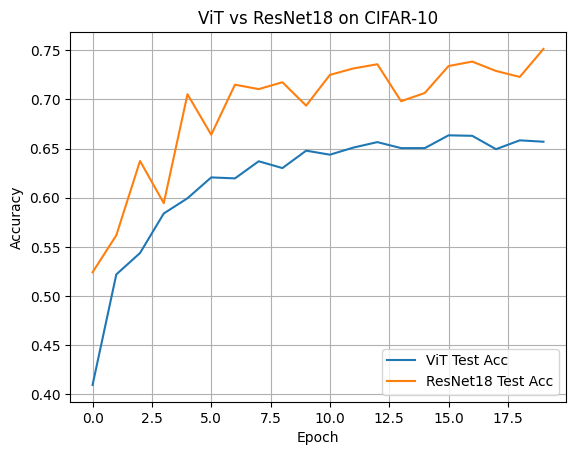

In [ ]:
plt.plot(vit_test_acc, label='ViT Test Acc')
plt.plot(res_test_acc, label='ResNet18 Test Acc')
plt.title('ViT vs ResNet18 on CIFAR-10')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()